# Transformer from Scratch

A Transformer based on the architecture presented in Vaswani et al. (2017) Attention is all you need. I train it on the complete works of Shakespeare for 1 epoch.  
  
  
Here's an example completion from the trained architecture (prompt in *italics*):  

> *This is it!*_] This is a god of love, I fear the shot out. I  
will be a pattern. Let him comply with the pikes. I am as the  
fishes in the moon, the highest compulsion of his endowments are to  
the trumpet, and besmear themselves to the Altar.

> FIRST SOLDIER.  
What is the matter that I am,  
That I might not wish the Turk?

> THIRD SOLDIER.  
Faith, he did; and he does’t not?

> FIRST CLOWN.  
He does, sir.

> FIRST CLOWN.  
Ay, he is mad, sir, he was not mad and drinking to say he was  
the hostess of a knave   
  
  For the project I only allowed myself to look at the Attention is All You Need paper except for two occasions: when I got confused about what $d_{model}$ meant and quickly checked the shape of the input for the attention layer at [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) and when I was writing the sampling function (which I copied with only small modifications from [here](https://github.com/ckkissane/deep_learning_curriculum/blob/master/solutions/1_Transformers.ipynb))

# Set up

Import some things we will need later and define the default device and types we will use for the model and data.

In [ ]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from matplotlib import pyplot as plt

factory_kwargs = {"device":"cuda", "dtype":torch.float}
plt.rcParams["figure.figsize"] = (8,6)

# Creating the architecture
Some notation I'll use:  
* N = batch size  
* T = sequence length  
* V = vocabulary size  
* D = dimension of the model
* H = hidden dimmension in the feed-forward NN

## Embedding

In [ ]:
class Embedding(nn.Module):
  """Maps sequences of integers from 0 to V (corresponding to a word in
  the vocabulary) to a corresponding sequence of embedding vectors"""

  def __init__(self, embed_dim, len_vocab, device="cpu", dtype=torch.float):
    super().__init__()
    self.embed_mat = nn.Parameter(torch.empty(len_vocab, embed_dim,
                                              device=device, dtype=dtype))
    nn.init.xavier_uniform_(self.embed_mat)

  def forward(self, x):
    """
    input: Tensor of shape (N, T)
    output: Tensor of shape (N, T, D)"""
    return self.embed_mat[x, :]

In [ ]:
N, T, D, V = 9, 35, 8, 91
x = torch.randint(0, V, (N, T), device=factory_kwargs["device"])
E = Embedding(D, V, **factory_kwargs)
E(x).shape

torch.Size([9, 35, 8])

In [ ]:
class PositionalEmbedding(nn.Module):
  """Adds a positional embedding matrix to the input. It also applies dropout
  on the result using p=0.1"""

  def __init__(self, embed_dim, max_len=200, device="cpu", dtype=torch.float):
    """
    input:
    seq_len: Number of tokens in the input (assumming shorter inputs are padded
    to get a consistent length)
    embed_dim: Dimension of embedding space
    """
    super().__init__()
    self.n_param = 10000
    assert embed_dim%2 == 0, "embed_dim must be divisible by 2"

    self.embed_matrix = torch.zeros(max_len, embed_dim, device=device, dtype=dtype)
    seq_pos = torch.arange(max_len, device=device)
    embed_pos = torch.arange(embed_dim//2, device=device)
    self.embed_matrix[:, ::2] = torch.sin(seq_pos.unsqueeze(1)/
                                          (self.n_param**(2*embed_pos/embed_dim)))
    self.embed_matrix[:, 1::2] = torch.cos(seq_pos.unsqueeze(1)/
                                          (self.n_param**(2*embed_pos/embed_dim)))
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    """
    input: Tensor of shape (N, T, D)
    output: Returns the input plus the positional embedding
    """
    return self.dropout(x + self.embed_matrix[:x.shape[-2]].unsqueeze(0))

Without dropout, we can compare the embedding to the results seen [here](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/#:~:text=To%20understand%20the%20above%20expression)

In [ ]:
N, T, D = 5, 35, 4
x = torch.zeros(N, T, D, **factory_kwargs)
PE = PositionalEmbedding(D, **factory_kwargs)
PE(x).shape

torch.Size([5, 35, 4])

## Attention Layer and Multihead Attention

In [ ]:
def create_mask(seq_len, device="cpu", dtype=torch.float):
  """Creates a triangular matrix which corresponds to a mask that stops the
  prediction of a position from attending to previous positions"""
  mask = (-1e10)*torch.ones(seq_len, seq_len, device=device, dtype=dtype)
  mask = torch.triu(mask, 1)
  return mask

In [ ]:
create_mask(4)

tensor([[ 0.0000e+00, -1.0000e+10, -1.0000e+10, -1.0000e+10],
        [ 0.0000e+00,  0.0000e+00, -1.0000e+10, -1.0000e+10],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+10],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])

In [ ]:
class AttentionLayer(nn.Module):
  """A single-headed attention layer"""

  def __init__(self, d_model, v_dim, self_mask=True, q_dim=None,
               device="cpu", dtype=torch.float):
    """
    input:
    d_model: Model's dimension
    v_dim: Dimension of output tensor
    self_mask: if True, applies the diagonal mask constructed with the function
    create_mask
    q_dim: Number of queries (if None default to v_dim)
    """

    super().__init__()
    kwargs = {"device": device, "dtype": dtype}
    if q_dim == None:
      q_dim = v_dim
    self.q_dim = q_dim
    self.has_mask = self_mask
    self.kwargs = kwargs

    self.Wq = nn.Parameter(torch.empty(q_dim, d_model, **kwargs))
    nn.init.xavier_uniform_(self.Wq)
    self.bq = nn.Parameter(torch.zeros(q_dim, **kwargs))
    self.Wk = nn.Parameter(torch.empty(q_dim, d_model, **kwargs))
    nn.init.xavier_uniform_(self.Wk)
    self.bk = nn.Parameter(torch.zeros(q_dim, **kwargs))
    self.Wv = nn.Parameter(torch.empty(v_dim, d_model, **kwargs))
    nn.init.xavier_uniform_(self.Wv)
    self.bv = nn.Parameter(torch.zeros(v_dim, **kwargs))

  def forward(self, x):
    """
    input: Tensor of shape (N, T, D)
    output: Tensor of shape (N, T, v_dim)
    """
    Q = F.linear(x, self.Wq, self.bq)
    K = F.linear(x, self.Wk, self.bk)
    V = F.linear(x, self.Wv, self.bv)
    similarity_score = (Q.matmul(K.transpose(-2,-1))/self.q_dim**0.5)
    if self.has_mask:
      mask = create_mask(similarity_score.shape[-1], **self.kwargs)
      similarity_score = similarity_score + mask
    return F.softmax(similarity_score, dim=-1).matmul(V)


In [ ]:
N, T, D, Vdim = 100, 8, 7, 9
x = torch.ones(N, T, D, **factory_kwargs)

AL = AttentionLayer(D, Vdim, **factory_kwargs)
AL(x).shape # Result must be of size (N, T, Vdim)

torch.Size([100, 8, 9])

In [ ]:
class MultiheadAttention(nn.Module):
  """A layer which runs n_heads self-attention heads in parallell and stacks their
  output in a single tensor"""

  def __init__(self, n_heads, d_model, self_mask=True, q_dim=None,
               device="cpu", dtype=torch.float):
    super().__init__()
    kwargs = {"device": device, "dtype": dtype}
    assert d_model%n_heads == 0, "Dimension of the model must be divisible by n_heads"
    v_dim = d_model//n_heads

    self.Wo = nn.Parameter(torch.empty(d_model, n_heads*v_dim, **kwargs))
    nn.init.xavier_uniform_(self.Wo)
    self.heads = []
    for _ in range(n_heads):
      self.heads.append(AttentionLayer(d_model, v_dim, self_mask, q_dim, **kwargs))


  def forward(self, x):
    """
    input: Tensor of shape (N, T, D)
    output: Tensor of shape (N, T, q_dim*n_heads)"""
    head_results = []
    for head in self.heads:
      head_results.append(head(x))
    return F.linear(torch.cat(head_results, dim=-1), self.Wo)

In [ ]:
N, T, D, n_heads = 100, 15, 8, 2
x = torch.zeros(N, T, D, **factory_kwargs)

MHA = MultiheadAttention(n_heads, D, **factory_kwargs)
assert MHA(x).shape == x.shape # Input and output must be the same size for residual connection
print(x.shape)

torch.Size([100, 15, 8])


## Transformer Classes

In [ ]:
class LayerNorm(nn.Module):
  """A layer normalization layer"""

  def __init__(self, n_features, device="cpu", dtype=torch.float):
    super().__init__()
    kwargs = {"device":device, "dtype": dtype}

    self.beta = nn.Parameter(torch.zeros(n_features, **kwargs))
    self.gamma = nn.Parameter(torch.ones(n_features, **kwargs))

  def forward(self, x):
    """
    input: Tensor of shape (N, T, D)
    output: Tensor of shape (N, T, D)
    """
    x = (x - x.mean(dim=-1, keepdim=True))/x.std(dim=-1, keepdim=True)
    return self.gamma*x - self.beta

In [ ]:
class TransformerBlock(nn.Module):
  """A Transformer block composed of a multi-headed self-attention layer followed by
  a fully connected feed-forward network. In addition, each block is surrounded by
  residual connections and feeds into a layer normalization component."""

  def __init__(self, n_heads, d_model, hidden_dim, self_mask=True, q_dim=None, device="cpu",
               dtype=torch.float):
    super().__init__()
    kwargs = {"device":device, "dtype": dtype}

    self.attention = MultiheadAttention(n_heads, d_model, self_mask, q_dim, **kwargs)
    self.batchnorm1 = LayerNorm(d_model, **kwargs)
    self.linear1 = nn.Linear(d_model, hidden_dim, **kwargs)
    self.linear2 = nn.Linear(hidden_dim, d_model, **kwargs)
    self.batchnorm2 = LayerNorm(d_model, **kwargs)
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    """
    input: Tensor of shape (N, T, D)
    output: Tensor of shape (N, T, D)
    """
    attention_out = self.dropout(self.attention(x))
    x = self.batchnorm1(attention_out + x)
    linear_out = self.dropout(F.relu(self.linear2(F.relu(self.linear1(x)))))
    return self.batchnorm2(linear_out + x)

In [ ]:
N, T, D, n_heads, H = 100, 15, 40, 4, 30
x = torch.zeros(N, T, D, **factory_kwargs)

TB = TransformerBlock(n_heads, D, H, **factory_kwargs)
TB(x).shape

torch.Size([100, 15, 40])

In [ ]:
class Transformer(nn.Module):
  """Encoder only Transformer which starts with a layer of learned embedding
  vectors followed by positional encoding, n_blocks Transformer Blocks and a
  fully connected feed-forward network. A more detailed description is found in
  Vaswani et al. (2017). Attention is all you need"""

  def __init__(self, n_blocks, n_heads, d_model, hidden_dim, len_vocab,
               q_dim=None, self_mask=True, device="cpu", dtype=torch.float):

    super().__init__()
    self.kwargs = {"device": device, "dtype": dtype}

    blocks = [TransformerBlock(n_heads, d_model, hidden_dim, self_mask, q_dim, **self.kwargs)
              for _ in range(n_blocks)]

    self.net = nn.Sequential(Embedding(d_model, len_vocab, **self.kwargs),
                             PositionalEmbedding(d_model, **self.kwargs),
                             *blocks,
                              nn.Linear(d_model, len_vocab, **self.kwargs))
    self.d_model = d_model

  def forward(self, x):
    """
    input: Tensor of shape (N, T) composed of integers from 0 to V
    output: Tensor of shape (N, T, V)
    """
    return self.net(x)


In [ ]:
N, T, D = 3, 35, 8
vocab, n_heads, n_blocks, H = 91, 2, 4, 30
x = torch.randint(low=0, high=vocab, size=(N,T), device=factory_kwargs["device"])

T = Transformer(n_blocks, n_heads, D, hidden_dim=H,
                len_vocab=vocab, **factory_kwargs)
T(x).shape

torch.Size([3, 35, 91])

# Testing the Transformer

## Defining helper classes and data functions


In [ ]:
import random
from math import ceil
import re

def get_src_tgt(data):
  """Divide data sequences into a source (input to the model) and a target (the
  sequence to be predicted). It assumes that data is a Tensor object or has a dim() function"""
  return (data[:,:-1], data[:,1:])

class Solver():

  def __init__(self, model, data, optimizer, val_frac=0.2):
    """
    A class with several tools to train and evaluate a model. As it trains it
    stores the loss after every step and the training and validation accuracy
    after every epoch

    Input:
    model: The model to be trained
    data: A data object that can be indexed to obtain training and validation data
    for the model
    optimizer: An optimizer object that allows us to update the model parameters
    val_frac: The fraction of data used for validation
    """
    self.model = model
    self.data = data
    self.optimizer = optimizer
    self.data_len = len(data)
    self.train_data_len = int((1-val_frac)*self.data_len)
    self.train_acc = []
    self.val_acc = []
    self.loss_hist = []
    self.steps = 0

    # We calculate train_acc only on 10% of the training set or 1000 examples
    k = min(1000, self.train_data_len//10)
    self.sample_train_idx = random.choices(range(self.data_len), k=k)
    self.val_data_idx = slice(self.train_data_len, self.data_len)

  def train(self, n_epochs=1, batch_size=128, print_every=1, warmup=None,
            verbose=True):
    """
    Input:
    n_epochs (float): Number of epochs to train for
    batch_size: Batch size
    print_every (float): If verbose=True, indicates the number of epochs in training
    before printing the loss, training accuracy and validation accuracy
    warmup: If not None, indicates the number of warmup steps for the learning
    rate schedule used in _Attention is All You Need_
    verbose: Whether to print updates on the performance of the model
    """

    D = self.model.d_model
    epoch_size = self.train_data_len
    steps_per_epoch = epoch_size//batch_size
    epoch = 0

    if type(print_every) == float:
      print_every_steps = ceil(print_every*steps_per_epoch)
      print_every = 1
    else:
      print_every_steps = 1e20

    i = 0
    while self.steps < n_epochs*steps_per_epoch:
      batch = self.data[i*batch_size:(i+1)*batch_size]
      src, tgt = get_src_tgt(batch)
      loss = self.train_step(src, tgt)
      self.steps += 1
      self.loss_hist.append(loss.item())

      if warmup != None:
        lr = (D**-.5)*min(self.steps**(-.5), self.steps*(warmup**(-1.5)))
        for g in self.optimizer.param_groups:
          g['lr'] = lr

      if verbose and self.steps%print_every_steps == 0:
        print(f"Epoch {round(self.steps/steps_per_epoch, 3)}. Loss {round(loss.item(), 4)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/10**9} GB")

      i += 1
      # Restart the counter after every epoch
      if i >= steps_per_epoch:
        i = 0
        epoch += 1

        train_acc_e = self.eval(self.sample_train_idx)
        self.train_acc.append(train_acc_e)
        val_acc_e = self.eval(self.val_data_idx)
        self.val_acc.append(val_acc_e)

        if verbose and epoch%print_every == 0:
          print(f"Epoch {epoch}. Loss {round(loss.item(), 4)}", end=" // ")
          print(f"Train Acc: {train_acc_e}. Val Acc: {val_acc_e}")

  @torch.no_grad()
  def eval(self, eval_idx, print_sample=False, vocab=None):
    """
    Returns the accuracy of the model on self.data[eval_idx].
    If print_sample is True, it prints a comparison between a randomly chosen
    target sequence and the prediction of the model.
    If vocab is not None, it uses the vocab object to map the integers in the
    predicted sequence to words.
    """
    self.model.eval()

    src, tgt = get_src_tgt(self.data[eval_idx])
    logits = self.model(src)
    logits_max, logits_pos = logits.max(dim=-1)
    eval_acc = (logits_pos == tgt).to(torch.float).mean().item()
    eval_acc = round(eval_acc, 3)

    if print_sample:
      i = random.choice(range(tgt.shape[0]))
      if vocab != None:
        print(f"Original: \n{''.join(vocab.lookup_tokens(tgt[i].tolist()))}")
        print(f"Modelo: \n{''.join(vocab.lookup_tokens(logits_pos[i].tolist()))}")
      else:
        print(f"Original: \n{tgt[i]} \nModelo: \n{logits_pos[i]}")

    return eval_acc

  # For the implementation of this function I took significant inspiration from
  # https://github.com/ckkissane/deep_learning_curriculum/blob/master/solutions/1_Transformers.ipynb

  def get_top_k(self, logits, k):
    values, idx = torch.topk(logits, k, dim=-1)
    out = torch.ones_like(logits)
    out = out*(-float("inf"))
    out[:, idx] = logits[:, idx]
    return out

  @torch.no_grad()
  def sample(self, context, steps, T, top_k, temperature=1, vocab=None):
    self.model.eval()
    if vocab != None:
      context = vocab.lookup_indices(re.split(r"\b", context))
      x = torch.Tensor(context).to(torch.long).to(self.model.kwargs["device"])
    else:
      x = context

    # I make sure that x has shape (N, T) even if N = 1
    if x.dim() == 1:
      x = x.unsqueeze(0)

    for i in range(steps):
      x_end = x if x.shape[1] < T else x[:, -T:]
      logits = self.model(x_end)
      logits = logits[:, -1, :]/temperature
      logits = self.get_top_k(logits, top_k)
      probs = F.softmax(logits, dim=-1)
      comp_x = torch.multinomial(probs, num_samples=1)
      x = torch.cat([x, comp_x], dim=1)

    if vocab != None:
      return ["".join(vocab.lookup_tokens(seq)) for seq in x.tolist()]
    return x

  # def export_predictions(self, file_name, eval_idx, vocab):
  #   self.model.eval()
  #   with torch.no_grad():
  #     src, tgt = get_src_tgt(eval_idx)
  #     out = self.model(src)
  #     out_max, out_pos = out.max(dim=-1)

  #   with open(file_name, "w") as file:
  #     for i in range(out.shape[0]):
  #       line1 = ''.join(vocab.lookup_tokens(tgt[i].tolist()))
  #       line2 = ''.join(vocab.lookup_tokens(out_pos[i].tolist()))
  #       file.write("Original: " + re.sub("(<null>)*", "", line1) + "\n")
  #       file.write("Modelo: " + re.sub("(<null>)*", "", line2) + "\n")

  def train_step(self, src, tgt):
    """Performs a training step on a mini-batch characterized by src and tgt"""
    self.model.train()
    self.optimizer.zero_grad()
    logits = self.model(src)
    if logits.shape[-1] != tgt.shape[-1]: # Because I don't follow the torch convention
      logits = logits.transpose(-2, -1)
    loss = F.cross_entropy(logits, tgt)
    loss.backward()
    self.optimizer.step()
    return loss


def gen_data_simple_string(N, T, vocab_len, weight=None, device="cpu", dtype=torch.int64):
  """Outputs N sequences of integers from 0 to vocab_len. Each sequence has length
  T and is padded with 0s at the extremes. If weight is None each integer is just
  as likely as any other"""
  sequences = []
  for _ in range(N):
    seq = random.choices(range(1, vocab_len), weights=weight, k=T)
    seq = torch.Tensor([0] + seq + [0]).to(torch.int64).to(device)
    sequences.append(seq)
  return torch.stack(sequences, dim=0)

def gen_data_reverse_string(N, T, vocab_len, device="cpu", dtype=torch.int64):
  """Outputs N symmetric sequences of integers from 0 to vocab_len.
  Each sequence has length T and is padded with 0s at the extremes. Each integer
  is just as likely as any other in the first half of the string"""
  sequences = []
  for _ in range(N):
    seq = random.choices(range(1, vocab_len), k=(T-2)//2)
    seq_reverse = seq.copy()
    seq_reverse.reverse()
    seq = torch.Tensor(tuple([0] + seq + seq_reverse + [0])).to(torch.int64).to(device)
    sequences.append(seq)
  return torch.stack(sequences, dim=0)

In [ ]:
print(gen_data_simple_string(3, 5, 5))
print(gen_data_reverse_string(3, 8, 5))

tensor([[0, 3, 4, 4, 2, 2, 0],
        [0, 4, 2, 2, 4, 4, 0],
        [0, 2, 2, 2, 3, 1, 0]])
tensor([[0, 2, 2, 1, 1, 2, 2, 0],
        [0, 2, 4, 4, 4, 4, 2, 0],
        [0, 4, 3, 2, 2, 3, 4, 0]])


## Testing on simple sequences

We check that the Transformer can learn the identity function. Given that we're not using masks it should be able to get perfect accuracy on the task.

In [ ]:
random.seed(0)

N, T, D, V = 5000, 12, 64, 9
n_blocks, n_heads, H = 2, 4, 100
model1 = Transformer(n_blocks, n_heads, D, hidden_dim=D, len_vocab=V, self_mask=False,
                       **factory_kwargs)

weight = [random.random() for _ in range(V-1)]
data = gen_data_simple_string(N, T, V, weight, **factory_kwargs)
optimizer = optim.Adam(model1.parameters(), lr=1e-2)

solver = Solver(model1, data, optimizer)
solver.train(n_epochs=5)

In [ ]:
test = slice(-5, -1)
solver.eval(test, print_sample=True)

We check the mask works correctly by predicting symmetrical strings. The model should be able to predict only the second part of the string (by mirroring the first part). Absent overfitting, the model should on average have an accuracy of 60% for the parameters given (a little larger than 50% because it can correctly predict some tokens on the first part of the string by chance)

In [ ]:
random.seed(0)

N, T, D, V = 5000, 12, 64, 9
n_blocks, n_heads, H = 2, 4, 100

model2 = Transformer(n_blocks, n_heads, D, hidden_dim=D, len_vocab=V,
                       **factory_kwargs)

data = gen_data_reverse_string(N, T, V, **factory_kwargs)
optimizer = optim.Adam(model2.parameters(), lr=1e-2)
solver = Solver(model2, data, optimizer)
solver.train(n_epochs=8)
print("Max Possible Acc: ", round((T + T/(V-1) - 2/(V-1))/(2*(T-1)), 3))

In [ ]:
test = slice(-5,-1)
solver.eval(test, print_sample=True)

In [ ]:
x = torch.Tensor([0, 1, 2, 3, 4, 5]).to(factory_kwargs["device"]).to(torch.long)
solver.sample(x, steps=6, T=T, top_k=1)

# Imitating Shakespeare

### Downloading text and parsing it

In [ ]:
from urllib.request import urlopen
import re
from collections import Counter, OrderedDict
from torchtext.vocab import vocab
from torch.utils.data import Dataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Download the complete works of Shakespeare
url = urlopen("https://www.gutenberg.org/files/100/100-0.txt")
book = url.read().decode('utf-8')
start = re.search("From fairest", book).start()
book = book[start:] # Skip the file description
tokenized = re.split(r"\b", book)

In [ ]:
tokenized[:20]

['',
 'From',
 ' ',
 'fairest',
 ' ',
 'creatures',
 ' ',
 'we',
 ' ',
 'desire',
 ' ',
 'increase',
 ',\r\n',
 'That',
 ' ',
 'thereby',
 ' ',
 'beauty',
 '’',
 's']

In [ ]:
# I only include tokens that appear at least twice because it makes the model train
# like 40% faster. It amounts to cutting the number of tokens in half
token_counter = OrderedDict(Counter(tokenized))
vocab1 = vocab(token_counter, min_freq=2, specials=['<unk>', "<null>"])
vocab1.set_default_index(vocab1["<unk>"])
print("Number of words in the the collected works: ", len(tokenized))
print("Length of the vocabulary: ", len(vocab1))

Number of words in the the collected works:  1987529
Length of the vocabulary:  20310


In [ ]:
class ShakespeareDataset():
  """A dataset object which can be indexed to sample N sequences of length T from
  vocab[text] (the integers that map through vocab to the original text)

  When you index the Dataset object, the index is randomly mapped to another integer
  from 0 to N, which is used to index T consecutive positions in vocab[text].
  Additionally, each sequence is padded at both sides with vocab["null"].

  If N is not specified, the class uses the maximum number of different sequences
  that it can create from the original text using the previous procedure
  (roughly the number of tokens in the text) """
  def __init__(self, T, text=tokenized, vocab=vocab1, pad_token="<null>",
               N=None, dtype=torch.long, device="cpu"):
    self.seq_len = T
    self.size = N
    self.transform = lambda l: torch.Tensor(l).to(dtype).to(device)
    self.corpus = self.transform(vocab.lookup_indices(text))
    self.pad_token = self.transform([vocab[pad_token]])
    self.shuffle_map = torch.randperm(len(self)).numpy()

  def __len__(self):
    if self.size == None:
      return len(self.corpus) - self.seq_len
    else:
      return self.size

  def __getitem__(self, idx):
    if isinstance(idx, int):
      idx_shuffle = self.shuffle_map[idx]
      text = self.corpus[idx_shuffle:idx_shuffle+self.seq_len]
      padded_text = torch.cat([self.pad_token, text, self.pad_token])
      return padded_text
    elif isinstance(idx, slice) or isinstance(idx, list):
      data = []
      for i in self.shuffle_map[idx]:
        text = self.corpus[i:i+self.seq_len]
        padded_text = torch.cat([self.pad_token, text, self.pad_token])
        data.append(padded_text)
      return torch.stack(data, dim=0)
    else:
      raise Exception(f"__getitem__ not implemented for type {type(idx)}")

### Learning from Shakespeare

First we train it for only in a small fraction of the data to make sure that the model starts reducing the loss. Sometimes the models gets stuck in a policy of predicting only blank spaces  

In [ ]:
from datetime import datetime

data = ShakespeareDataset(T=64, device=factory_kwargs["device"])
N, T = len(data), 64

D, V = 512, len(vocab1)
n_blocks, n_heads, H = 6, 8, 2048

model = Transformer(n_blocks, n_heads, D, hidden_dim=D, len_vocab=V,
                       **factory_kwargs)

optimizer = optim.Adam(model.parameters())
solver = Solver(model, data, optimizer, val_frac=0.01)
# The validation sample is small so it doesn't overflow the GPU's memory
# (I haven't implemented evaluating the model in batches)

start_time = datetime.now()
solver.train(n_epochs=0.1, warmup=3000, print_every=0.01)
end_time = datetime.now()
print('Time training 0.1 epoch: {}'.format(end_time - start_time))

Epoch 0.01. Loss 5.6451
Memory Allocated: 0.464793088 GB
Epoch 0.02. Loss 4.9987
Memory Allocated: 0.464793088 GB
Epoch 0.03. Loss 4.9574
Memory Allocated: 0.464793088 GB
Epoch 0.04. Loss 5.0297
Memory Allocated: 0.464793088 GB
Epoch 0.05. Loss 4.9329
Memory Allocated: 0.464793088 GB
Epoch 0.06. Loss 4.9827
Memory Allocated: 0.464793088 GB
Epoch 0.07. Loss 4.1894
Memory Allocated: 0.464793088 GB
Epoch 0.08. Loss 3.9962
Memory Allocated: 0.464793088 GB
Epoch 0.09. Loss 4.0174
Memory Allocated: 0.464793088 GB
Time training 0.1 epoch: 0:12:16.856011


In [ ]:
# Let's see how it's going
context = "This is it!"
print(solver.sample(context, steps=200, T=T, top_k=5, vocab=vocab1)[0])

<unk>This is it!KING, I, I you and not,
I you is a lord and a <unk>,
    The lord with the <unk> of the the <unk>,
And to I I I the the <unk> of the man the <unk>,
And the <unk> of <unk> the his the man of of his his <unk> of
That a man of his a the the man <unk> and
And’s man of the man <unk> of of <unk>,
To of the the the world to and of the the his man,
    But. That to the a man of the man.

d the lord.

_.
      The lord 


And now let's train it for 1 epoch. I'd train it for longer, but it would involve policing Colab a lot to stop it from terminating the session.




In [ ]:
solver.train(n_epochs=1, warmup=3000, print_every=0.1)

Epoch 0.2. Loss 3.4102
Memory Allocated: 0.464793088 GB
Epoch 0.3. Loss 3.079
Memory Allocated: 0.464793088 GB
Epoch 0.4. Loss 2.8036
Memory Allocated: 0.464793088 GB
Epoch 0.5. Loss 2.668
Memory Allocated: 0.464793088 GB
Epoch 0.6. Loss 2.5534
Memory Allocated: 0.464793088 GB
Epoch 0.7. Loss 2.4556
Memory Allocated: 0.464793088 GB
Epoch 0.8. Loss 2.39
Memory Allocated: 0.464793088 GB
Epoch 0.901. Loss 2.3055
Memory Allocated: 0.464793088 GB
Epoch 1.001. Loss 2.2536
Memory Allocated: 0.464793088 GB


In [ ]:
context = "This is it!"
print(solver.sample(context, steps=200, T=T, top_k=5, vocab=vocab1)[0])

<unk>This is it!_] This is a god of love, I fear the shot out. I
will be a pattern. Let him comply with the pikes. I am as the
fishes in the moon, the highest compulsion of his endowments are to
the trumpet, and besmear themselves to the Altar.

FIRST SOLDIER.
What is the matter that I am,
That I might not wish the Turk?

THIRD SOLDIER.
Faith, he did; and he does’t not?

FIRST CLOWN.
He does, sir.

FIRST CLOWN.
Ay, he is mad, sir, he was not mad and drinking to say he was
the hostess of a knave 


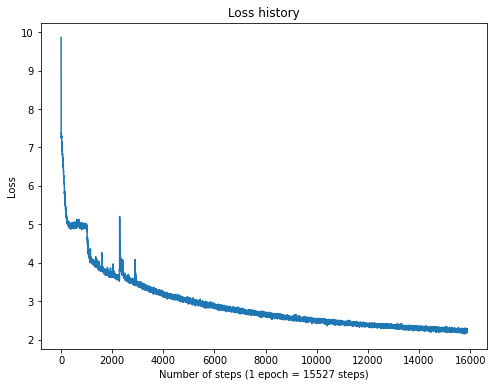

In [ ]:
plt.plot(solver.loss_hist)
plt.title("Loss history")
plt.xlabel(f"Number of steps (1 epoch = {round(len(data)/128)} steps)")
_ = plt.ylabel("Loss")